In [220]:
import pandas as pd
from gymnasium import Env
from gymnasium.spaces import Box, Dict, Discrete, MultiDiscrete
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from copy import copy
import ray
import seaborn as sns
import pandas as pd

In [171]:
class Architecture:
    def __init__(self):
        self.c_capacity, self.s_capacity = 50, 2
        self.weights = [0.0125, 0.0010, 0.0200, 0.5000] # REVIEW
        self.lifetime = {0: 1, 1: 2, 2: 3, 3: 10}   # REVIEW
        self.max_actions = 10
        self.num_c = 2
        self.num_s = 6
        self.max_actions = 10
        self.min_free_space = 0.2
        self.space_flag = -1

        self.data_types = []
        self.data_allocation = []
        self.data_times = []

        self.false_data_types = []
        self.false_data_allocation = []
        self.false_data = {}
        self.false_devices = {}

        self.data = {}
        self.devices = {}
        self.latencies = {}
        self.max_latencies = {}

        self.action_device = []
        self.action_type = []

        for j in (range(len(self.weights))):
            self.data[j] = {}
            self.false_data[j] = {}
            for i in range(self.num_s+self.num_c):
                self.data[j][i] = 0
                self.false_data[j][i] = 0
                self.devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.false_devices[i] = {0: 0, 1: 0, 2: 0, 3: 0}
                self.latencies[i] = {}
                self.max_latencies[i] = {}

        for i in self.latencies.keys():
            for j in self.latencies.keys():
                self.latencies[i][j] = 0
                self.max_latencies[i][j] = 0

        devices = list(self.devices.keys())
        bound = round(len(self.devices)/4)
        self.clusters = {
            0: devices[bound*3:],
            1: devices[bound:bound*2],
            2: devices[bound*2:bound*3],
            # 3: devices[:bound]
            3: [0]
        }
        self.visualization()

    def construct_dictionaries(self):
        for i in self.data:
            for j in self.data[i]:
                self.data[i][j] = 0
        for i in self.devices:
            for j in self.devices[i]:
                self.devices[i][j] = 0
        for device, d_type in zip(self.data_allocation, self.data_types):
            self.data[d_type][device] += 1
            self.devices[device][d_type] += 1

    def false_construct_dictionaries(self):
        for i in self.false_data:
            for j in self.false_data[i]:
                self.false_data[i][j] = 0
        for i in self.false_devices:
            for j in self.false_devices[i]:
                self.false_devices[i][j] = 0
        for device, d_type in zip(self.false_data_allocation, self.false_data_types):
            self.false_data[d_type][device] += 1
            self.false_devices[device][d_type] += 1

    def update(self, data_type, device):
        self.data_types.append(data_type)
        self.data_allocation.append(device)
        self.data_times.append(0)
        self.devices[device][data_type] += 1
        self.data[data_type][device] += 1

    def heart_beat(self):
        deads = []
        for i in range(len(self.data_times)):
            self.data_times[i] += 1
            if self.data_times[i] == self.lifetime[self.data_types[i]]:
                deads.append(i)

        removed = 0
        for i in deads:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i - removed)
            self.data_times.pop(i - removed)
            removed += 1

    def free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.devices[i].values()), self.weights)]))/self.s_capacity
            if load[i] <= self.min_free_space:
                self.space_flag = i
        return load

    def false_free_space(self):
        load = {}
        for i in range(self.num_c + self.num_s):
            if i < self.num_c:
                load[i] = (self.c_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.c_capacity
            else:
                load[i] = (self.s_capacity - sum([a*b for a,b in zip(list(self.false_devices[i].values()), self.weights)]))/self.s_capacity
            # if load[i] <= self.min_free_space:
            #     self.space_flag = i
        return load

    def reduce_type(self, data_type):
        max_time = 0
        positions = []
        for i in range(len(self.data_allocation)):
            if self.data_types[i] == data_type:
                if self.data_times[i] > max_time:
                    max_time = self.data_times[i]
                    positions = []
                    positions.append(i)
                elif self.data_times[i] == max_time:
                    positions.append(i)

        removed = 0
        for i in positions:
            self.devices[self.data_allocation[i-removed]][self.data_types[i-removed]] -= 1
            self.data[self.data_types[i-removed]][self.data_allocation[i-removed]] -= 1
            self.data_times.pop(i - removed)
            self.data_types.pop(i - removed)
            self.data_allocation.pop(i -removed)
            removed += 1

    def check_quantity(self, data_type):
        if data_type != 3:
            if sum(list(self.data[data_type].values())) > 2*(self.num_s + self.num_c):
                self.reduce_type(data_type)
        else:
            if sum(list(self.data[data_type].values())) > 2*self.num_s:
                self.reduce_type(data_type)

    def visualization(self):
        keys = list(self.devices.keys())
        cs = keys[:self.num_c]
        ss = keys[self.num_c:]

        colors = []
        sizes = []

        graph = nx.Graph()

        colors.append('lightblue')
        sizes.append(1000)
        index = 0
        for i in range(len(cs)):
            if i != len(cs)-1:
                colors.append('lightblue')
                sizes.append(1000)
                graph.add_edge(cs[i],cs[i+1])
                graph.add_weighted_edges_from([(cs[i],cs[i+1],10)])
                for j in range(int(len(ss)/self.num_c)):
                    colors.append('orange')
                    sizes.append(100)
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    index += 1
            else:
                graph.add_edge(cs[i],cs[0])
                graph.add_weighted_edges_from([(cs[i],cs[0],10)])
                for j in range(int(len(ss)/self.num_c)+len(ss)%self.num_c):
                    graph.add_edge(cs[i],ss[index])
                    graph.add_weighted_edges_from([(cs[i],ss[index],random.randint(4,6))])
                    colors.append('orange')
                    sizes.append(100)
                    index += 1

        pos = nx.spring_layout(graph)  # Position nodes using a spring layout algorithm
        # nx.draw(graph, pos, with_labels=True, node_size=sizes, node_color=colors, font_weight=12, font_color='black', edge_color='gray')
        edge_labels = nx.get_edge_attributes(graph, 'weight')
        # nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

        # plt.title("Architecture:")
        # plt.axis('off')
        # plt.show()

        for u in graph.nodes:
            shortest_paths = nx.shortest_path_length(graph, source=u, weight='weight')
            for v, weight in shortest_paths.items():
                self.latencies[u][v] = weight

        max_latency = self.latencies[self.num_c][self.num_c+self.num_s-1]
        for i in self.max_latencies.keys():
            for j in self.max_latencies[i].keys():
                self.max_latencies[i][j] = max_latency

    def compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def false_compute_total_latency(self):
        total_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.false_data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
        return total_latency

    def compute_normalized_latency(self):
        total_latency = 0
        max_latency = 0
        for i in range(len(self.action_type)):
            total_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.latencies[self.action_device[i]].values())])
            max_latency += sum([a*b for a,b in zip(self.data[self.action_type[i]].values(), self.max_latencies[self.action_device[i]].values())])
        return total_latency/(max_latency+1)

    def compute_normalized_latency_dict(self):    # CHANGEEEEEEEEEEEEEE
        total_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }
        max_latency = {
            0: 0,
            1: 0,
            2: 0,
            3: 0
        }

        for key in total_latency.keys():
            for dev in range(len(self.clusters[key])):
                if self.clusters[key][dev] in self.action_device:
                    for j in self.data[key]:
                        total_latency[key] += self.latencies[self.clusters[key][dev]][j] * self.data[key][j]
                        max_latency[key] += self.data[key][j]
        for i in total_latency.keys():
            total_latency[i] = 1-total_latency[i]/(max_latency[i]*22+1)

        return total_latency

    # def rl_update(self, new_allocation):
    #     self.data_allocation = new_allocation
    #     self.construct_dictionaries()
    #     return self.free_space()

    def generate(self, operation):
        if operation == 0 or operation == 1 or operation == 2:
            for i in range(self.num_s + self.num_c):
                self.update(operation,i)
            self.check_quantity(operation)
        elif operation == 3:
            for i in range(self.num_c,(self.num_c + self.num_s)):
                self.update(operation,i)
            self.check_quantity(operation)
        else:
            device=random.sample(self.clusters[operation-10],1)[0] if operation != 13 else self.clusters[operation-10][0] # CHANGEEEEEEEEEEEEEEE
            # device=self.clusters[operation - 10][0]
            self.action_device.append(device)
            self.action_type.append(operation-10)
            difference = len(self.action_device) - self.max_actions
            if difference >= 0:
                for i in range(difference):
                    self.action_device.pop(0)
                    self.action_type.pop(0)

    def round_robin(self):
        allocation_round = []
        capacities = [50,50,2,2,2,2,2,2]  # CHANGEEEEEEEEEEEEEEEEEEEEE
        index = 0
        server_index = 0
        for i in range(len(self.data_allocation)):
            if index == self.num_c + self.num_s:
                index = 0
            if (index != 0 or index != 1) and capacities[index] - self.weights[self.data_types[i]] <= 0.2 * 2:      # CHANGEEEEEEEEEEEEEEEEEEEEE
                allocation_round.append(server_index)
                capacities[server_index] -= self.weights[self.data_types[i]]
                server_index = 1 if server_index == 0 else 0
            else:
                allocation_round.append(index)
                capacities[index] -= self.weights[self.data_types[i]]
                index += 1
        self.data_allocation = allocation_round.copy()
        self.construct_dictionaries()
        for i in range(52 - len(allocation_round)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_round.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_round

    def greedy_server(self):
        allocation_greedy= []
        index = 0
        for i in range(len(self.data_allocation)):
            allocation_greedy.append(index)
            index = 1 if index == 0 else 0          # CHANGEEEEEEEEEEEEEEEEEEEEE
        self.data_allocation = allocation_greedy.copy()
        self.construct_dictionaries()
        for i in range(52 - len(allocation_greedy)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
            allocation_greedy.append(random.randint(0,self.num_c+self.num_s-1))
        return allocation_greedy

    def greedy_algorithm(self):
        if self.space_flag == -1:
            # print("It's ok")
            allocation = []
            for i in self.data_types:
                allocation.append(random.sample(list(self.clusters[i]),1)[0])
            self.data_allocation = allocation.copy()
            self.construct_dictionaries()
            for i in range(52 - len(allocation)):      # REMEMBER TO CHANGE !!!!!!!!!!!!!!
                allocation.append(random.randint(0,self.num_c+self.num_s-1))
            return allocation
        else:
            # print("Problem")
            problematic_key = None
            for key, value in self.clusters.items():
                if self.space_flag in value:
                    problematic_key = key
                    break
            for i in range(self.num_c):
                self.clusters[problematic_key].append(i)
            self.space_flag = -1
            return self.greedy_algorithm()

In [6]:
executions = [[0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,10],
              [0,1,2,11],
              [0,1,2,12],
              [0,1,2,3],
              [0,1,2,13]]

architecture = Architecture()

print(architecture.clusters)

for j in executions:
    architecture.heart_beat()
    for h in j:
        architecture.generate(h)
    # print(architecture.data)
    print(architecture.action_device)
    print(architecture.action_type)
    # architecture.round_robin()
    # print(architecture.compute_normalized_latency_dict())
    # architecture.greedy_server()
    # print(architecture.compute_normalized_latency_dict())

{0: [6, 7], 1: [2, 3], 2: [4, 5], 3: [0]}
[6]
[0]
[6, 2]
[0, 1]
[6, 2, 5]
[0, 1, 2]
[6, 2, 5]
[0, 1, 2]
[6, 2, 5, 6]
[0, 1, 2, 0]
[6, 2, 5, 6, 2]
[0, 1, 2, 0, 1]
[6, 2, 5, 6, 2, 5]
[0, 1, 2, 0, 1, 2]
[6, 2, 5, 6, 2, 5]
[0, 1, 2, 0, 1, 2]
[6, 2, 5, 6, 2, 5, 0]
[0, 1, 2, 0, 1, 2, 3]


In [172]:
class AcesStepArchitectureEnv(Env):
    def __init__(self, maximum_data):
        self.architecture = Architecture()
        self.executions = [[0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,10],
                           [0,1,2,11],
                           [0,1,2,12],
                           [0,1,2,3],
                           [0,1,2,13]]
        self.execution_index = 0
        self.num_devices = len(self.architecture.devices.keys())
        self.maximum_data = maximum_data

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity]
        self.max_free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity,
                               self.architecture.s_capacity,self.architecture.s_capacity]
        self.quantity = 0
        self.last_call = [-1]
        self.weight = 0
        self.type = 0

        self.observation_space = Dict({
            "quantity": Discrete(maximum_data+1, start=0),
            "weight": Box(low=0, high=1, shape=(1,), dtype=np.float32),
            "free_space": Box(low=-10, high=50, shape=(self.num_devices,), dtype=np.float32),
            "last_calls": Box(low=-1, high=7, shape=(2,), dtype=np.int32)               # CHAAAAAAAAAAAAAAAAAAAAAAAAAANGE
        })

        self.action_space = Box(low=0, high=self.num_devices-1, shape=(maximum_data,), dtype=np.int32)

        self.reward = 0

    def get_obs(self, type):
        self.quantity = sum(self.architecture.data[type].values())
        self.weight = self.architecture.weights[type]
        indices = set()
        for i in range(len(self.architecture.action_type)):
            if self.architecture.action_type[i]==type:
                indices.add(self.architecture.action_device[i])
        if len(indices) == 2:
            self.last_call = list(indices)              # CHAAAAAAAAAAAAAAAAAAAAAAAAAANGE
        elif len(indices) == 1:
            self.last_call = list(indices)
            self.last_call.append(-1)
        else:
            self.last_call = [-1,-1]
        return {
            "quantity": self.quantity,
            "weight": np.array([self.weight]),
            "free_space": np.array(self.free_space),
            "last_calls": np.array(self.last_call)
        }

    def step(self,action):
        cut_action = action[:self.quantity]
        latency = 0
        flag = False
        computed_latencies = 0              #CHANGEEEEEEEEEEEEEEE
        for location in cut_action:
            for call in self.last_call:
                if call != -1:
                    latency += self.architecture.latencies[call][location]
                    computed_latencies+=1
            self.free_space[location] -= self.weight
            if self.free_space[location] <= self.max_free_space[location]*0.2:
                flag = True

        if flag:
            reward = -1
        else:
            reward = 1 - (latency / (computed_latencies * 22+1))             # CHANGEEEEEEEEEEEEEEEEEEEEEE

        if self.type == 3:
            done = True
        else:
            done = False
            self.type += 1

        info = {}

        return self.get_obs(self.type), reward, done, info

    def reset(self):
        self.architecture.heart_beat()
        for execution in self.executions[self.execution_index]:
            self.architecture.generate(execution)

        self.free_space = [self.architecture.c_capacity,self.architecture.c_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity,
                           self.architecture.s_capacity,self.architecture.s_capacity]

        self.execution_index = self.execution_index +1 if self.execution_index <= len(self.executions) - 2 else 0
        self.type = 0
        return self.get_obs(self.type)

    def close(self):
        print('CLOSED')

In [8]:
ar = AcesStepArchitectureEnv(16)
ar.reset()
# ar.step(ar.action_space.sample())

{'quantity': 8,
 'weight': array([0.0125]),
 'free_space': array([50, 50,  2,  2,  2,  2,  2,  2]),
 'last_calls': array([ 6, -1])}

In [90]:
from ray.rllib.utils import check_env
from gymnasium.wrappers import EnvCompatibility

simulated_aces = AcesStepArchitectureEnv(16)
check_env(EnvCompatibility(simulated_aces))

2023-06-11 17:35:21,103	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-06-11 17:35:21,105	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.


In [29]:
from ray.tune.registry import register_env
from gymnasium.wrappers import EnvCompatibility
from ray.rllib.algorithms.impala import ImpalaConfig
from ray.rllib.algorithms.ppo import PPOConfig
from gymnasium.wrappers import TimeLimit

ray.shutdown()

architecture = Architecture()

def env_creator(env_config):
    return TimeLimit(EnvCompatibility(AcesStepArchitectureEnv(16)), max_episode_steps=10)
register_env("AcesStepArchitectureEnv", env_creator)

config = (
    ImpalaConfig()
    .environment("AcesStepArchitectureEnv",disable_env_checking=True)
    .rollouts(num_rollout_workers=40,
              num_envs_per_worker=5) # Max = 60
    .resources(num_gpus=0,
               num_cpus_per_worker=1)
    .training(entropy_coeff=0.02)
)

# config['model']['vf_share_layers'] = False
config["model"]["fcnet_hiddens"] =[64,64]


algorithm_6 = config.build()

result_6 =[]

for j in tqdm(range(125)):
    result_train = algorithm_6.train()["episode_reward_mean"]
    result_6.append(result_train)
    # if (j%25 == 0):
    print(result_train)
print(result_6)

2023-06-21 20:02:39,732	INFO worker.py:1553 -- Started a local Ray instance.
2023-06-21 20:02:53,485	INFO trainable.py:172 -- Trainable.setup took 15.854 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-06-21 20:02:53,486	WARNING util.py:67 -- Install gputil for GPU system monitoring.
  1%|█▍                                                                                                                                                                            | 1/125 [00:12<25:31, 12.35s/it]

1.9331358383298012


  2%|██▊                                                                                                                                                                           | 2/125 [00:25<25:47, 12.58s/it]

2.4387551096193416


  2%|████▏                                                                                                                                                                         | 3/125 [00:37<25:33, 12.57s/it]

2.1419453989728234


  3%|█████▌                                                                                                                                                                        | 4/125 [00:50<25:34, 12.68s/it]

2.027106144013904


  4%|██████▉                                                                                                                                                                       | 5/125 [01:03<25:29, 12.74s/it]

2.565114873749707


  5%|████████▎                                                                                                                                                                     | 6/125 [01:15<25:08, 12.68s/it]

2.5984489780790216


  6%|█████████▋                                                                                                                                                                    | 7/125 [01:28<24:57, 12.69s/it]

2.5473681155645176


  6%|███████████▏                                                                                                                                                                  | 8/125 [01:41<24:44, 12.69s/it]

1.5834212384980044


  7%|████████████▌                                                                                                                                                                 | 9/125 [01:53<24:19, 12.59s/it]

1.772555973371067


  8%|█████████████▊                                                                                                                                                               | 10/125 [02:06<24:06, 12.58s/it]

2.1579819920397183


  9%|███████████████▏                                                                                                                                                             | 11/125 [02:18<23:48, 12.53s/it]

2.4952460327434016


 10%|████████████████▌                                                                                                                                                            | 12/125 [02:31<23:38, 12.56s/it]

2.5598748863733363


 10%|█████████████████▉                                                                                                                                                           | 13/125 [02:43<23:20, 12.51s/it]

2.4461575204018047


Exception in thread Thread-240:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/learner_thread.py", line 74, in run
    self.step()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/multi_gpu_learner_thread.py", line 143, in step
    buffer_idx, released = self.ready_tower_stacks_buffer.get()
  File "/home/rcalzada/.local/lib/python3.10/site-packages/ray/rllib/execution/minibatch_buffer.py", line 48, in get
    self.buffers[self.idx] = self.inqueue.get(timeout=self.timeout)
  File "/usr/lib/python3.10/queue.py", line 179, in get
    raise Empty
_queue.Empty
 11%|███████████████████▍                                                                                                                                                         | 14/125 [02:56<23:06, 12.49s/it]

2.5047142540576584


 12%|████████████████████▊                                                                                                                                                        | 15/125 [03:08<23:04, 12.58s/it]

2.0788434548021137


 13%|██████████████████████▏                                                                                                                                                      | 16/125 [03:21<22:46, 12.54s/it]

1.7138904449009291


 14%|███████████████████████▌                                                                                                                                                     | 17/125 [03:33<22:35, 12.55s/it]

2.5837725708164436


 14%|████████████████████████▉                                                                                                                                                    | 18/125 [03:46<22:25, 12.58s/it]

1.4806154523797574


 15%|██████████████████████████▎                                                                                                                                                  | 19/125 [03:58<22:04, 12.49s/it]

2.102187362178468


 16%|███████████████████████████▋                                                                                                                                                 | 20/125 [04:11<21:54, 12.52s/it]

1.9701830138121383


 17%|█████████████████████████████                                                                                                                                                | 21/125 [04:24<21:47, 12.58s/it]

1.8506351402335277


 18%|██████████████████████████████▍                                                                                                                                              | 22/125 [04:36<21:34, 12.57s/it]

2.428473514267818


 18%|███████████████████████████████▊                                                                                                                                             | 23/125 [04:49<21:23, 12.58s/it]

1.7378825203413895


 19%|█████████████████████████████████▏                                                                                                                                           | 24/125 [05:01<21:11, 12.59s/it]

2.0627733260622185


 20%|██████████████████████████████████▌                                                                                                                                          | 25/125 [05:14<20:52, 12.53s/it]

2.516967412557343


 21%|███████████████████████████████████▉                                                                                                                                         | 26/125 [05:26<20:44, 12.57s/it]

2.247728134697086


 22%|█████████████████████████████████████▎                                                                                                                                       | 27/125 [05:39<20:32, 12.58s/it]

2.4623605472445824


 22%|██████████████████████████████████████▊                                                                                                                                      | 28/125 [05:52<20:18, 12.56s/it]

2.566706637868781


 23%|████████████████████████████████████████▏                                                                                                                                    | 29/125 [06:04<20:08, 12.59s/it]

2.6053663007499877


 24%|█████████████████████████████████████████▌                                                                                                                                   | 30/125 [06:17<19:47, 12.50s/it]

2.354337964317914


 25%|██████████████████████████████████████████▉                                                                                                                                  | 31/125 [06:29<19:37, 12.52s/it]

2.561031732235977


 26%|████████████████████████████████████████████▎                                                                                                                                | 32/125 [06:42<19:21, 12.49s/it]

1.6616913483620477


 26%|█████████████████████████████████████████████▋                                                                                                                               | 33/125 [06:54<19:13, 12.54s/it]

1.8966583154674432


 27%|███████████████████████████████████████████████                                                                                                                              | 34/125 [07:07<19:04, 12.58s/it]

1.8067501397752694


 28%|████████████████████████████████████████████████▍                                                                                                                            | 35/125 [07:20<18:56, 12.62s/it]

2.38103481804251


 29%|█████████████████████████████████████████████████▊                                                                                                                           | 36/125 [07:32<18:35, 12.53s/it]

2.54776134404646


 30%|███████████████████████████████████████████████████▏                                                                                                                         | 37/125 [07:45<18:34, 12.66s/it]

1.4570752636444702


 30%|████████████████████████████████████████████████████▌                                                                                                                        | 38/125 [07:57<18:18, 12.63s/it]

2.0449740206684277


 31%|█████████████████████████████████████████████████████▉                                                                                                                       | 39/125 [08:10<18:10, 12.68s/it]

1.808080989038753


 32%|███████████████████████████████████████████████████████▎                                                                                                                     | 40/125 [08:23<17:50, 12.59s/it]

2.2126585507506897


 33%|████████████████████████████████████████████████████████▋                                                                                                                    | 41/125 [08:35<17:37, 12.58s/it]

2.4179572740250888


 34%|██████████████████████████████████████████████████████████▏                                                                                                                  | 42/125 [08:48<17:25, 12.59s/it]

2.2428771119362243


 34%|███████████████████████████████████████████████████████████▌                                                                                                                 | 43/125 [09:00<17:14, 12.62s/it]

1.417548090597322


 35%|████████████████████████████████████████████████████████████▉                                                                                                                | 44/125 [09:13<16:54, 12.52s/it]

2.2990258732688247


 36%|██████████████████████████████████████████████████████████████▎                                                                                                              | 45/125 [09:25<16:41, 12.52s/it]

2.359770364470944


 37%|███████████████████████████████████████████████████████████████▋                                                                                                             | 46/125 [09:38<16:31, 12.55s/it]

2.2579352595020707


 38%|█████████████████████████████████████████████████████████████████                                                                                                            | 47/125 [09:50<16:12, 12.47s/it]

1.5132047209452222


 38%|██████████████████████████████████████████████████████████████████▍                                                                                                          | 48/125 [10:03<15:58, 12.45s/it]

2.0224840976261595


 39%|███████████████████████████████████████████████████████████████████▊                                                                                                         | 49/125 [10:15<15:46, 12.46s/it]

2.3151739833446134


 40%|█████████████████████████████████████████████████████████████████████▏                                                                                                       | 50/125 [10:28<15:37, 12.50s/it]

2.147168368424418


 41%|██████████████████████████████████████████████████████████████████████▌                                                                                                      | 51/125 [10:40<15:20, 12.44s/it]

2.0114831372244804


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                     | 52/125 [10:52<15:09, 12.46s/it]

2.5351546031717485


 42%|█████████████████████████████████████████████████████████████████████████▎                                                                                                   | 53/125 [11:05<15:01, 12.52s/it]

2.589032686507518


 43%|██████████████████████████████████████████████████████████████████████████▋                                                                                                  | 54/125 [11:17<14:43, 12.45s/it]

2.6008960218603026


 44%|████████████████████████████████████████████████████████████████████████████                                                                                                 | 55/125 [11:30<14:31, 12.44s/it]

2.3128218590961827


 45%|█████████████████████████████████████████████████████████████████████████████▌                                                                                               | 56/125 [11:42<14:21, 12.48s/it]

2.420204089532465


 46%|██████████████████████████████████████████████████████████████████████████████▉                                                                                              | 57/125 [11:55<14:10, 12.51s/it]

2.4631254263199924


 46%|████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 58/125 [12:08<14:02, 12.58s/it]

2.4552745482213254


 47%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 59/125 [12:20<13:46, 12.52s/it]

2.5240754440015603


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 60/125 [12:33<13:37, 12.57s/it]

2.6308575116234065


 48%|███████████████████████████████████████████████████████████████████████████████████                                                                                          | 60/125 [12:35<13:38, 12.59s/it]


KeyboardInterrupt: 

In [47]:
checkpoint_path_6 = algorithm_6.save("./TFM/algorithms/6stations_2points")

In [99]:
ray.shutdown()
recover_6 = config.build()
recover_6.restore("./TFM/algorithms/6stations_2points/checkpoint_000060")
recover_6_result = []
for j in tqdm(range(5)):
    result_train = recover_6.train()["episode_reward_mean"]
    recover_6_result.append(result_train)
    # if (j%10 == 0):
    print(result_train)
print(recover_6_result)

2023-06-21 20:25:13,964	INFO worker.py:1553 -- Started a local Ray instance.
(RolloutWorker pid=3453870) 2023-06-21 20:25:21,271	ERROR worker.py:772 -- Exception raised in creation task: The actor died because of an error raised in its creation task, ray::RolloutWorker.__init__() (pid=3453870, ip=138.4.11.229, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x7f808dc08af0>)
(RolloutWorker pid=3453870)   File "/home/rcalzada/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py", line 569, in make
(RolloutWorker pid=3453870)     _check_version_exists(ns, name, version)
(RolloutWorker pid=3453870)   File "/home/rcalzada/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py", line 219, in _check_version_exists
(RolloutWorker pid=3453870)     _check_name_exists(ns, name)
(RolloutWorker pid=3453870)   File "/home/rcalzada/.local/lib/python3.10/site-packages/gymnasium/envs/registration.py", line 197, in _check_name_exists
(RolloutWorker pid=3453870

EnvError: The env string you provided ('AcesStepArchitectureEnv') is:
a) Not a supported/installed environment.
b) Not a tune-registered environment creator.
c) Not a valid env class string.

Try one of the following:
a) For Atari support: `pip install gym[atari] autorom[accept-rom-license]`.
   For VizDoom support: Install VizDoom
   (https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md) and
   `pip install vizdoomgym`.
   For PyBullet support: `pip install pybullet`.
b) To register your custom env, do `from ray import tune;
   tune.register('[name]', lambda cfg: [return env obj from here using cfg])`.
   Then in your config, do `config['env'] = [name]`.
c) Make sure you provide a fully qualified classpath, e.g.:
   `ray.rllib.examples.env.repeat_after_me_env.RepeatAfterMeEnv`


(0.0, 59.0)

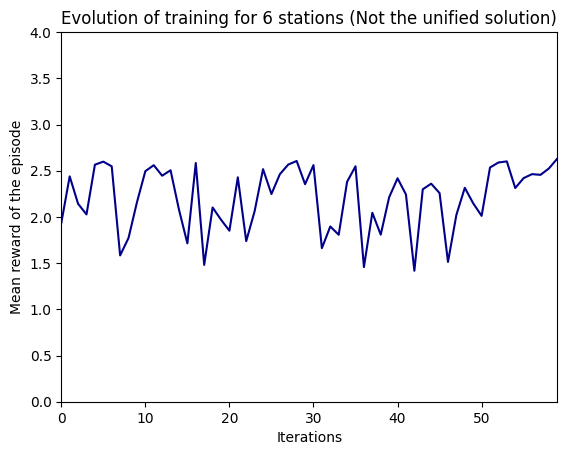

In [160]:
plt.plot(result_6, color='darkblue')
plt.title("Evolution of training for 6 stations (Not the unified solution)")
plt.xlabel("Iterations")
plt.ylabel("Mean reward of the episode")
plt.ylim(0,4)
plt.xlim(0,59)

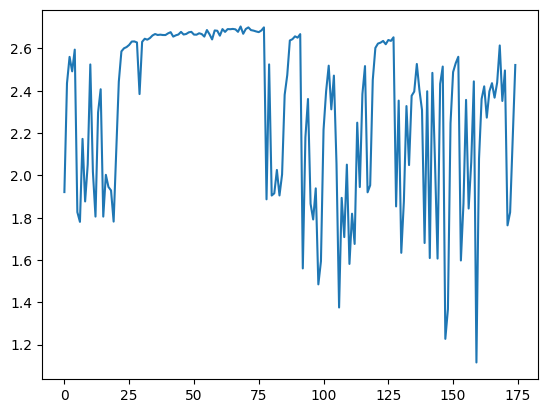

In [15]:
plt.plot(result_6)

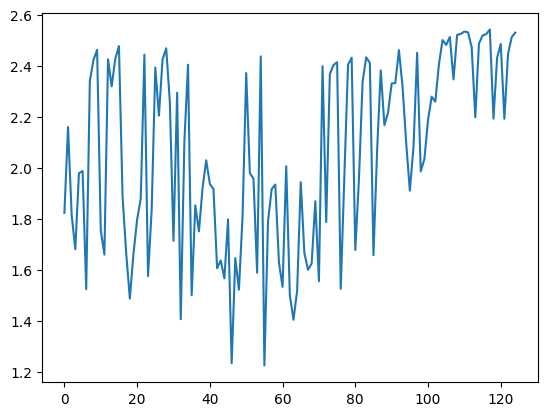

In [210]:
plt.plot(result_first)
# len(result_first)

In [193]:
test_architecture = AcesStepArchitectureEnv(16)
latency_round_robin = []
latency_best_device = []
latency_algorithm = []
free_spaces = []
rewards = []

In [194]:
for i in range(100):
    obs = test_architecture.reset()
    test_architecture.architecture.round_robin()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    latency_round_robin.append(test_architecture.architecture.compute_total_latency())
    test_architecture.architecture.greedy_server()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    latency_best_device.append(test_architecture.architecture.compute_total_latency())
    test_architecture.architecture.greedy_algorithm()
    # print(test_architecture.architecture.compute_normalized_latency_dict())
    # print(test_architecture.architecture.compute_total_latency())
    iteration = {}
    allocation = []
    type = []
    reward = 0
    for i in range(4):
        action = algorithm_6.compute_single_action(obs)
        output = test_architecture.step(action)
        obs = output[0]
        reward += output[1]
        iteration[i] = output[1]
        if i==0:
            for i in range(8):
                allocation.append(action[i])
                type.append(0)
        elif i==1:
            for i in range(16):
                allocation.append(action[i])
                type.append(1)
        elif i==2:
            for i in range(16):
                allocation.append(action[i])
                type.append(2)
        else:
            for i in range(12):
                allocation.append(action[i])
                type.append(3)

    # print(allocation)
    # print(type)
    test_architecture.architecture.false_data_allocation = allocation
    test_architecture.architecture.false_data_types = type
    test_architecture.architecture.false_construct_dictionaries()
    # print(iteration)
    latency_algorithm.append(test_architecture.architecture.false_compute_total_latency())
    free_spaces.append(test_architecture.architecture.false_free_space())
    rewards.append(reward)

(0.0, 99.0)

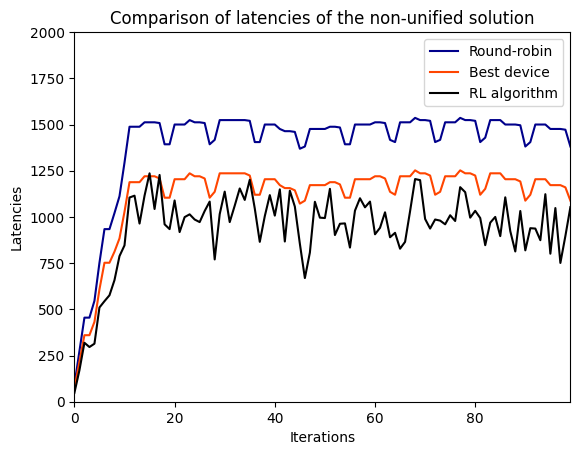

In [200]:
# plt.plot(result_6, color='darkblue')
plt.plot(latency_round_robin, color='darkblue', label = "Round-robin")
plt.plot(latency_best_device, color='orangered', label = "Best device")
plt.plot(latency_algorithm, color='black', label = "RL algorithm")
plt.title("Comparison of latencies of the non-unified solution")
plt.xlabel("Iterations")
plt.ylabel("Latencies")
plt.legend()
plt.ylim(0, 2000)
plt.xlim(0, 99)

In [257]:
free_space_check = []

for fs_ind in range(len(free_spaces)):
    a=0
    for key in free_spaces[fs_ind].keys():
        if free_spaces[fs_ind][key] <= 0.2:
            a=rewards[fs_ind]
    free_space_check.append(a)

(0.0, 99.0)

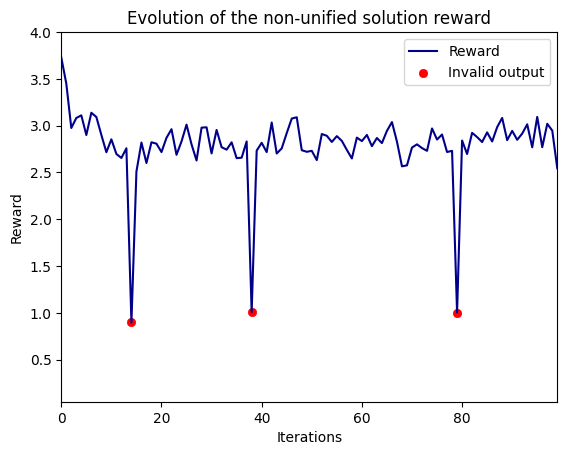

In [269]:
line=plt.plot(rewards, color='darkblue', label = "RL algorithm")
point=plt.scatter(range(0,100,1),free_space_check,color='red',linewidths=0.5)
plt.title("Evolution of the non-unified solution reward")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.legend((line[0],point),('Reward','Invalid output'))
plt.ylim(0.05, 4)
plt.xlim(0, 99)

In [232]:
pre_dataframe = {}
for i in range(8):
    pre_dataframe[i] = []
for fs in free_spaces:
    for key in fs.keys():
        pre_dataframe[key].append(fs[key])
df = pd.DataFrame.from_dict(pre_dataframe)

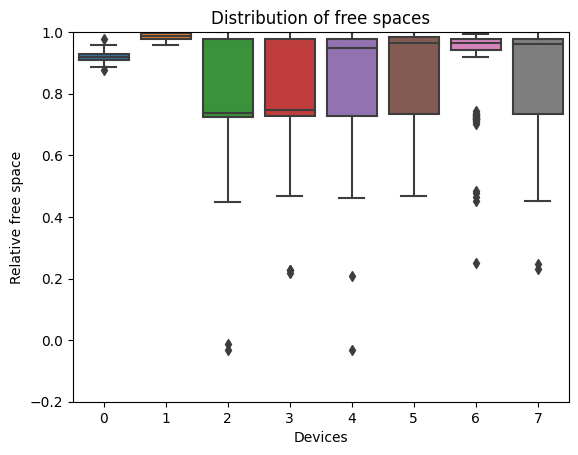

In [287]:
ax = sns.boxplot(data=df).set(
    title="Distribution of free spaces",
    xlabel="Devices",
    ylabel="Relative free space",
    ylim=(-0.2,1.0)
    )

<Axes: >

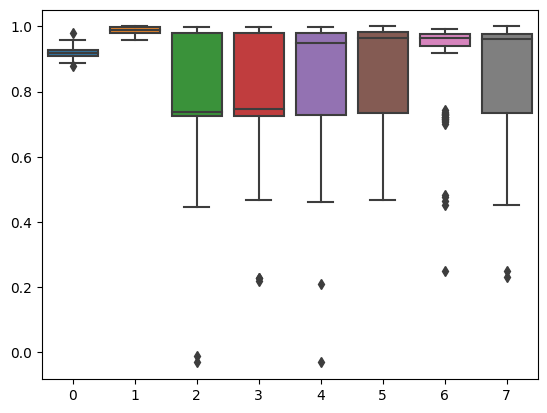